#### Calculate mean and standard deviation of difference between actual rolling returns and returns calculated using CAPM model for symbols belonging to NSE IT with a specific set of windows sizes and risk free rate. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
price_df = pd.read_csv('datasets/adj_closes_nseit_idx_20150101_20210430.csv')
price_df = price_df.set_index('Date')
rets_df  = (price_df/price_df.shift(1) - 1).round(6) 
rets_df  = rets_df.dropna(axis=0, how='any')

In [4]:
def cal_rets_capm(rets_df, sym, mkt_sym, window, rf, ret_df):
    data_df = pd.DataFrame(index=rets_df.index)
    data_df = pd.merge(data_df, rets_df[sym].rolling(window=window).mean(), left_index=True, right_index=True).rename(columns={sym:'actual_rets'})
    sim_df = (rets_df[sym].rolling(window=window).cov(rets_df[mkt_sym], ddof=0) / rets_df[mkt_sym].rolling(window=window).var(ddof=0)).to_frame().rename(columns={0:'beta'})
    sim_df['capm_rets'] = rf + sim_df['beta'] * ( rets_df[mkt_sym].rolling(window=window).mean() - rf )
    data_df = pd.merge(data_df, sim_df, left_index=True, right_index=True)
    data_df = data_df.dropna(axis=0, how='any')
    data_df['rets_diff'] = (data_df['actual_rets'] - data_df['capm_rets']).round(6)
    
    if ret_df == False:
        return data_df['rets_diff'].mean(), data_df['rets_diff'].std()
    else:
        return data_df['rets_diff'].mean(), data_df['rets_diff'].std(), data_df

In [10]:
def cal_stats(rets_df, mkt_sym, window, rf, ret_df=False):
    syms = [ val for val in list(rets_df.columns) if val != mkt_sym ]
    stats_df = pd.DataFrame(columns=['symbol', 'mean', 'std'])
    for idx, sym in enumerate(syms):
        if ret_df == False:
            sym_mean, sym_std = cal_rets_capm(rets_df, sym, mkt_sym, window, rf, ret_df)
        else:
            sym_mean, sym_std, df = cal_rets_capm(rets_df, sym, mkt_sym, window, rf, ret_df)
            df.plot(y=['actual_rets', 'capm_rets'], figsize=(12,6), grid=True, title='Actual and CAPM returns for {}'.format(sym), rot=30)
            plt.show()
            
        stats_df.loc[idx] = [sym, sym_mean, sym_std ]
        
    return stats_df

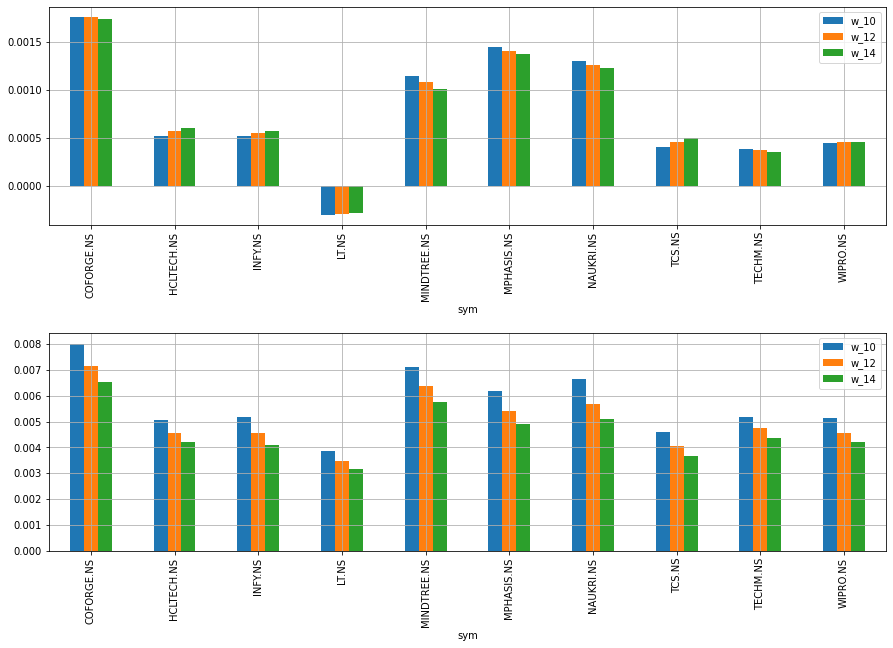

In [12]:
mkt_sym, rf, plot_rets = '^NSEI', 0, False 
windows = np.arange(10, 16, 2)
mdf_mean = pd.DataFrame()
mdf_std  = pd.DataFrame()
syms = [ val for val in rets_df if val != mkt_sym]
mdf_mean['sym'] = syms
mdf_std['sym']  = syms
for w in windows:
    df = cal_stats(rets_df, mkt_sym, w, rf, plot_rets)
    mdf_mean['w' + '_' + str(w)] = df['mean']
    mdf_std['w' + '_' + str(w)]  = df['std']

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
mdf_mean.plot(x='sym', grid=True, kind='bar', ax=axes[0])
mdf_std.plot(x='sym', grid=True, kind='bar', ax=axes[1])
plt.show()